In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
from keras_tuner import RandomSearch
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import re
from stop_words import get_stop_words
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

/Users/rohangupta/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Using TensorFlow backend


In [3]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


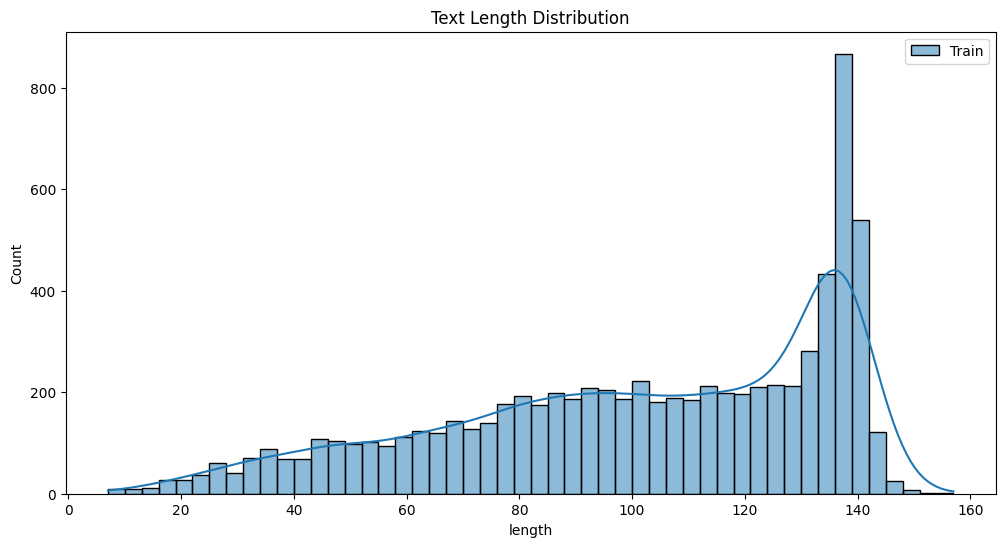

In [7]:
# text length distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_train['length'], bins=50, kde=True, label='Train')
plt.title('Text Length Distribution')
plt.legend()
plt.show()

In [8]:
print("\nTarget Variable Distribution:")
print(df_train['target'].value_counts())
print(df_train['target'].value_counts(normalize=True))


Target Variable Distribution:
target
0    4342
1    3271
Name: count, dtype: int64
target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


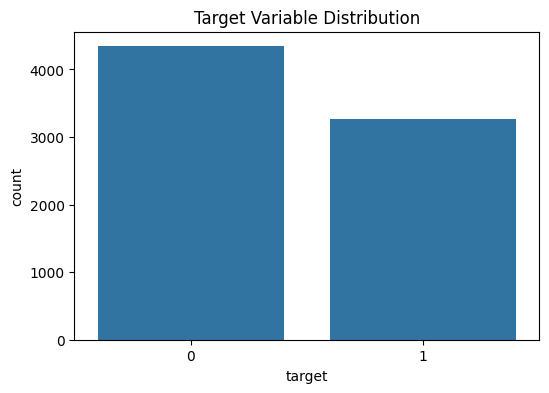

In [9]:
# Class Distribution

plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df_train)
plt.title('Target Variable Distribution')
plt.show()

In [10]:
# Calculate class weights for loss function

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train['target']),
    y=df_train['target'].values
)
class_weights = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights}")

Class Weights: {0: 0.8766697374481806, 1: 1.1637114032405993}


In [11]:
# Keyword Analysis
print("\nKeyword Analysis:")
print(df_train['keyword'].value_counts().head(10))


Keyword Analysis:
keyword
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
Name: count, dtype: int64


In [12]:
# Location Analysis
print("\nLocation Analysis:")
print(df_train['location'].value_counts().head(10))


Location Analysis:
location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: count, dtype: int64


In [13]:
print("\nMissing Values in Train:")
print(df_train.isnull().sum())
print("\nMissing Values in Test:")
print(df_test.isnull().sum())


Missing Values in Train:
id             0
keyword       61
location    2533
text           0
target         0
length         0
dtype: int64

Missing Values in Test:
id             0
keyword       26
location    1105
text           0
length         0
dtype: int64


In [14]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\S+', '', text)    # Remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove non-alphabetic characters
    text = text.lower()
    tokens = text.split()
    stop_words = get_stop_words('en')
    stop_words.append("amp") # '&' simple is amp in data, this is a stop word so appending to list
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

df_train['cleaned_text'] = df_train['text'].apply(clean_text)
df_test['cleaned_text'] = df_test['text'].apply(clean_text)

In [15]:
df_train.head()

,id,keyword,location,text,target,length,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,"[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,"[people, receive, wildfires, evacuation, order..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,"[just, got, sent, photo, ruby, alaska, smoke, ..."


In [16]:
# Word Frequency analysis
def get_top_words(df, target=None, n=20):
    if target is not None:
        df = df[df['target'] == target]
    all_words = [word for tokens in df['cleaned_text'] for word in tokens]
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

top_words_disaster = get_top_words(df_train, target=1)
top_words_non_disaster = get_top_words(df_train, target=0)

print("\nTop 20 Words in Disaster Tweets:")
print(top_words_disaster)

print("\nTop 20 Words in Non-Disaster Tweets:")
print(top_words_non_disaster)


Top 20 Words in Disaster Tweets:
[('fire', 180), ('news', 138), ('via', 121), ('disaster', 117), ('california', 111), ('suicide', 110), ('police', 107), ('people', 105), ('killed', 93), ('like', 92), ('pm', 89), ('hiroshima', 89), ('just', 86), ('storm', 85), ('us', 84), ('crash', 84), ('fires', 84), ('families', 81), ('train', 79), ('will', 78)]

Top 20 Words in Non-Disaster Tweets:
[('like', 253), ('im', 248), ('just', 234), ('will', 179), ('new', 170), ('get', 163), ('dont', 154), ('now', 147), ('one', 128), ('can', 122), ('body', 113), ('via', 99), ('video', 96), ('love', 90), ('people', 90), ('cant', 86), ('us', 86), ('know', 85), ('time', 84), ('back', 84)]


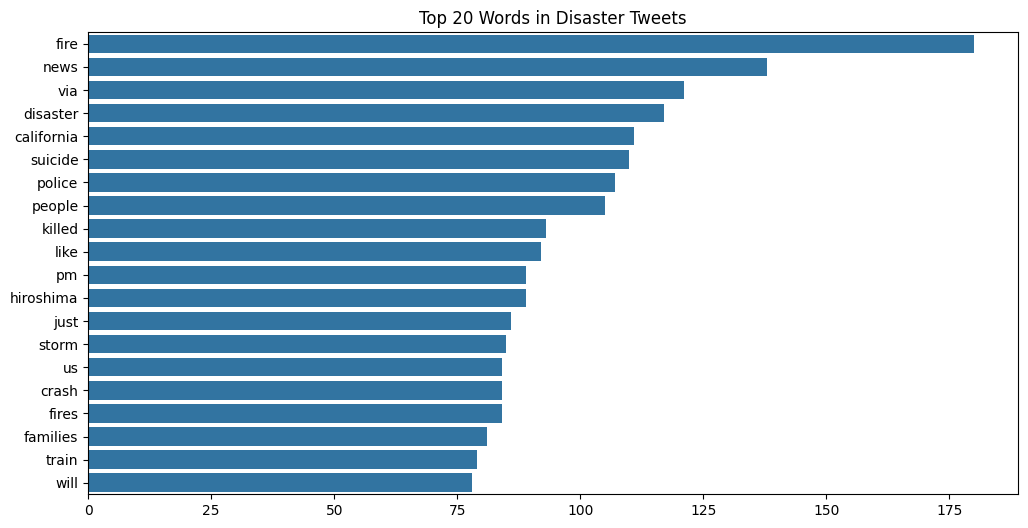

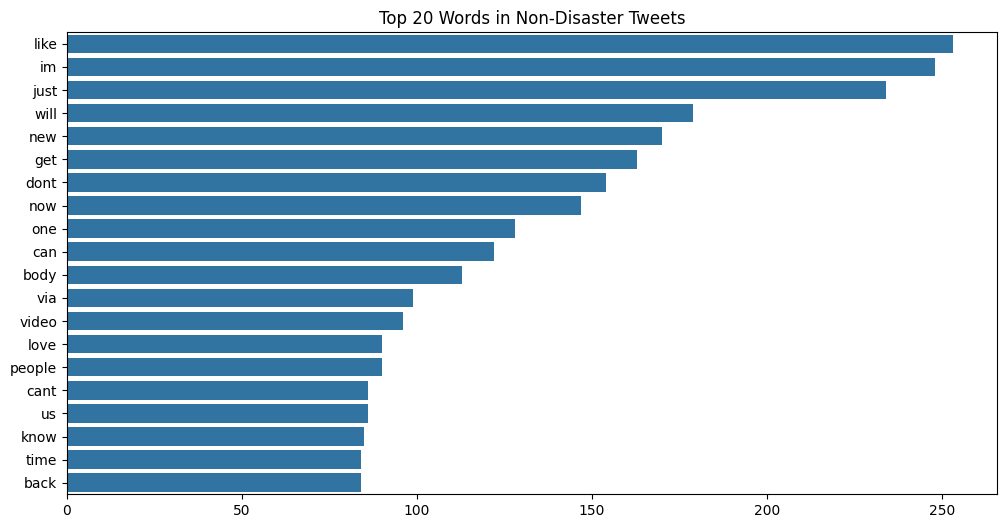

In [17]:
# Visualizing Top Words
def plot_top_words(word_counts, title):
    words, counts = zip(*word_counts)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(title)
    plt.show()

plot_top_words(top_words_disaster, "Top 20 Words in Disaster Tweets")
plot_top_words(top_words_non_disaster, "Top 20 Words in Non-Disaster Tweets")

In [18]:
# Tokenization
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['cleaned_text'])
X_train_seq = tokenizer.texts_to_sequences(df_train['cleaned_text'])
X_test_seq = tokenizer.texts_to_sequences(df_test['cleaned_text'])

# Padding
max_length = max([len(x) for x in X_train_seq])
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [19]:
X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X_train_padded, y, test_size=0.2, random_state=42)

X_test = df_test["text"]

In [20]:
# Model architecture
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128

model = Sequential([
    Embedding(vocab_size, 100),  # Reduced embedding dimension
    Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)),  # Added recurrent dropout
    Dropout(0.5),  # Increased dropout
    Dense(64, activation='relu', kernel_regularizer='l2'),  # Added L2 regularization
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [21]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [22]:
def build_model(hp):
    model = Sequential()
    
    # Tune embedding dimension
    model.add(Embedding(
        vocab_size,
        output_dim=hp.Int('embedding_dim', min_value=50, max_value=300, step=50)
    ))
    
    # Tune LSTM units and dropout
    model.add(Bidirectional(LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=128, step=32),
        dropout=hp.Float('lstm_dropout', min_value=0.2, max_value=0.5, step=0.1),
        recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.2, max_value=0.5, step=0.1)
    )))
    
    # Tune dense layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(
            hp.Float('l2_rate', min_value=0.0001, max_value=0.01, step=0.001)
        )
    ))
    
    model.add(Dropout(hp.Float('dense_dropout', min_value=0.3, max_value=0.6, step=0.1)))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # Tune learning rate
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    )
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='disaster_tweets'
)

# Callbacks
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3),
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy', mode='max'),
]

# Run the search
tuner.search(
    X_train, y_train,
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    batch_size=64
)

# Get best model
best_model = tuner.get_best_models(num_models=1)[0]


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
100               |100               |embedding_dim
64                |64                |lstm_units
0.4               |0.4               |lstm_dropout
0.3               |0.3               |recurrent_dropout
128               |128               |dense_units
0.0031            |0.0031            |l2_rate
0.3               |0.3               |dense_dropout
0.0001            |0.0001            |learning_rate

Epoch 1/30


In [ ]:
# Print a summary of the search results
tuner.results_summary()

# Retrieve the best model and its hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(best_hp.values)

In [ ]:
best_model.summary()

In [ ]:
# Train the model
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # Let early stopping handle termination
    batch_size=64,  # Try smaller batches
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/50


In [ ]:
# Extract history data
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

In [ ]:
# Create subplots
plt.figure(figsize=(14, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'bo-', label='Training loss')  # Blue circles with line
plt.plot(epochs, val_loss_values, 'r^-', label='Validation loss')  # Red triangles with line
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r^-', label='Validation accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
# Single plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, loss_values, color=color, linestyle='--', label='Train Loss')
ax1.plot(epochs, val_loss_values, color=color, label='Val Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(epochs, accuracy, color=color, linestyle='--', label='Train Acc')
ax2.plot(epochs, val_accuracy, color=color, label='Val Acc')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Training Dynamics')
fig.tight_layout()
plt.show()

In [ ]:
# Make predictions on the padded test data
test_predictions = model.predict(X_test_padded)
test_predictions =(test_predictions.squeeze() > 0.5).astype(int)

# Create submission DataFrame
submission_df = pd.DataFrame({
    'id': df_test['id'],
    'target': test_predictions.flatten()  # Flatten from 2D array to 1D
})

# Save to CSV
submission_df.to_csv('submission.csv', index=False)

print("Submission file saved as submission.csv")